In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
from scipy.io import readsav
from matplotlib import cm
import cartopy.crs as ccrs
from scipy.ndimage import gaussian_filter
import pickle
import glob

homedir = os.path.expanduser("~")
datadir = f"{homedir}/uoedrive/data/gcm_hires/w1049b-sept2025"

In [2]:
# read high-res gcm data
spectrum = np.loadtxt(f"{datadir}/high-resolution/spectrum_erg.s.cm3_broaden_time1.txt")
spec_nobroad = np.loadtxt(f"{datadir}/high-resolution/spectrum_erg.s.cm3_nobroaden_time1.txt")
wl = np.loadtxt(f"{datadir}/high-resolution/wavelength_micron.txt")

In [3]:
wl.shape

(460654,)

In [4]:
l_orders = [
    [3.10, 3.15],
    [3.14, 3.19],
    [3.19, 3.24],
    [3.23, 3.27]
]

(13347,)

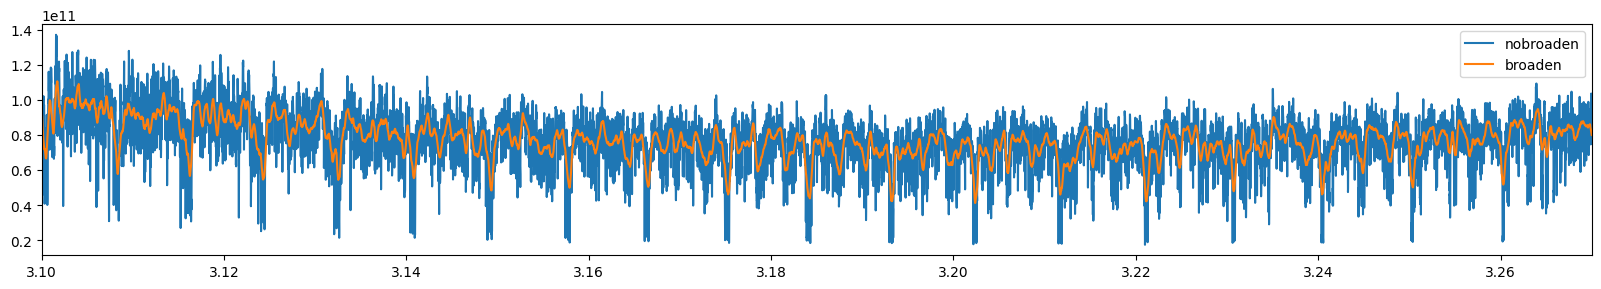

In [5]:
wlind = np.where((wl>np.min(l_orders)) & (wl<np.max(l_orders)))[0]
plt.figure(figsize=(20,3))
plt.plot(wl[wlind], spec_nobroad[wlind], label='nobroaden')
plt.plot(wl[wlind], spectrum[wlind], label='broaden')
plt.xlim(np.min(l_orders), np.max(l_orders))
plt.legend()
wlind.shape

In [6]:
for i in range(len(l_orders)):
    print(np.where((wl>l_orders[i][0]) & (wl<l_orders[i][1]))[0].shape)

(4000,)
(3950,)
(3888,)
(3077,)


In [7]:
# make data pickles
# wav is [nchip, npix]
# obs is [nt, nchip, npix]

npix = 2000
nchip = len(l_orders)
wav = np.empty((nchip, npix))
observed = np.empty((20, nchip, npix))
error = np.empty((20, nchip, npix))
template = np.empty((20, nchip, npix))

for t in range(20):
    spec_nobroad = np.loadtxt(f"{datadir}/high-resolution/spectrum_erg.s.cm3_nobroaden_time{t+1}.txt")
    spectrum = np.loadtxt(f"{datadir}/high-resolution/spectrum_erg.s.cm3_broaden_time{t+1}.txt")
    for c in range(nchip):
        wlmin, wlmax = l_orders[c]
        wlind = np.where((wl>wlmin) & (wl<wlmax))[0]
        if len(wlind) != npix:
            x_old = np.linspace(0, 1, len(wlind))
            x_new = np.linspace(0, 1, npix)
            wav[c] = np.interp(x_new, x_old, wl[wlind])
            data = np.interp(x_new, x_old, spectrum[wlind])
            model = np.interp(x_new, x_old, spec_nobroad[wlind])
        else:
            wav[c] = wl[wlind]
            data = spectrum[wlind][:npix]
            model = spec_nobroad[wlind][:npix]
        observed[t,c] = data/np.nanmedian(data)
        template[t,c] = model/np.nanmedian(model)
        size = 5
        sigma = np.array([np.std(observed[t,c][max(0,i-size):min(len(data),i+size+1)]) for i in range(len(data))]) # local running std as error
        error[t,c] = sigma

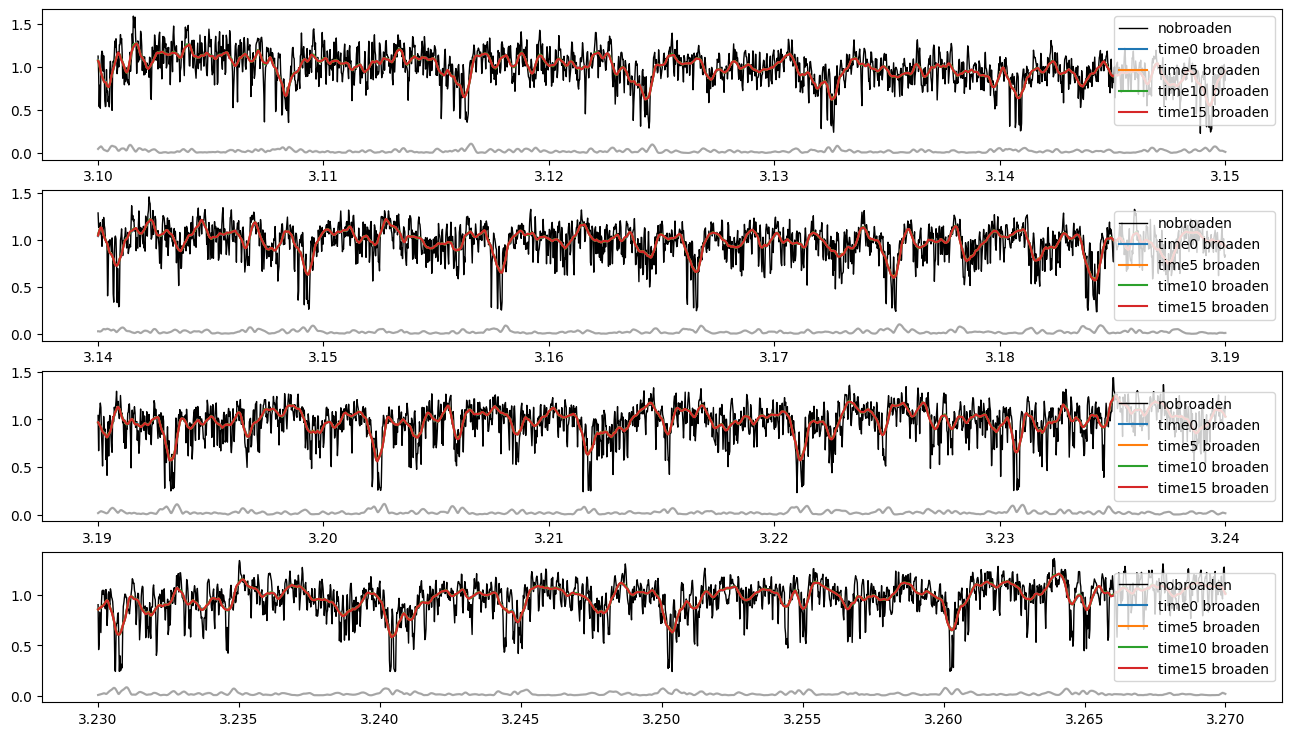

In [8]:
plt.figure(figsize=(16,9))
for c in range(nchip):
    wlmin, wlmax = l_orders[c]
    plt.subplot(nchip,1,c+1)
    plt.plot(wav[c], np.nanmedian(template[:,c,:],axis=0), color='k', linewidth=1, label=f'nobroaden')
    for t in [0,5,10,15]:
        plt.plot(wav[c], observed[t,c], label=f'time{t} broaden')
        plt.plot(wav[c], error[t,c], color='k', alpha=0.1)
    plt.legend()

In [9]:
# prepare pickle file
saveout = dict(
    chiplams=np.tile(wav, (20, 1, 1)), 
    chipmodnobroad=template, 
    observed=observed, 
    error=error)
with open(f'../data/fitted/METIS_W1049B_L_gcm.pickle', 'wb') as f:
    pickle.dump(saveout, f)

In [10]:
with open('../data/fitted/METIS_W1049B_L_gcm.pickle', 'rb') as f:
    data = pickle.load(f)
    print(data['chiplams'].shape)

(20, 4, 2000)


In [11]:
# read diamondback model
fname = f"{homedir}/uoedrive/data/diamondback/spectra/t1400g1000f2_m0.0_co1.0.spec"
model = np.loadtxt(fname, skiprows=4)
modwl = model[:,0]
modflux = model[:,1]

(13347,)

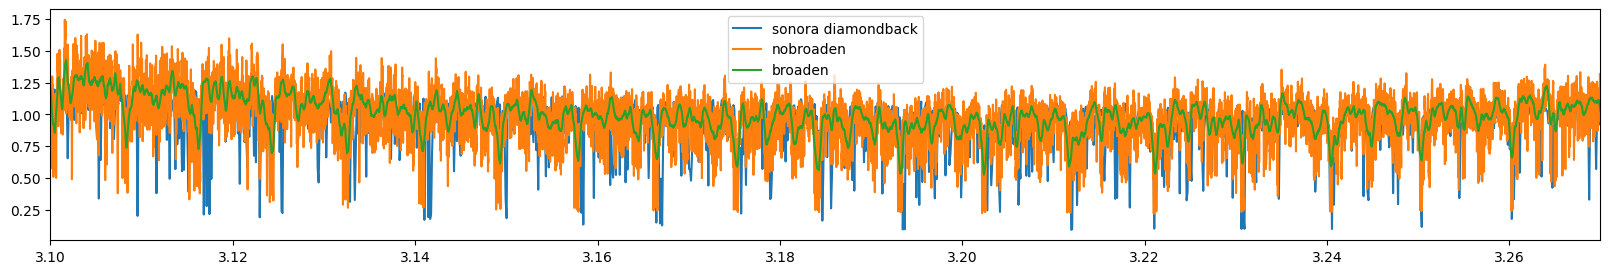

In [12]:
wlind = np.where((modwl>np.min(l_orders)) & (modwl<np.max(l_orders)))[0]
plt.figure(figsize=(20,3))
plt.plot(modwl[wlind], modflux[wlind]/np.nanmedian(modflux[wlind]), label='sonora diamondback')
wlind = np.where((wl>np.min(l_orders)) & (wl<np.max(l_orders)))[0]
plt.plot(wl[wlind], spec_nobroad[wlind]/np.nanmedian(spec_nobroad[wlind]), label='nobroaden')
plt.plot(wl[wlind], spectrum[wlind]/np.nanmedian(spectrum[wlind]), label='broaden')
plt.xlim(np.min(l_orders), np.max(l_orders))
plt.legend()
wlind.shape

480
474
466
369


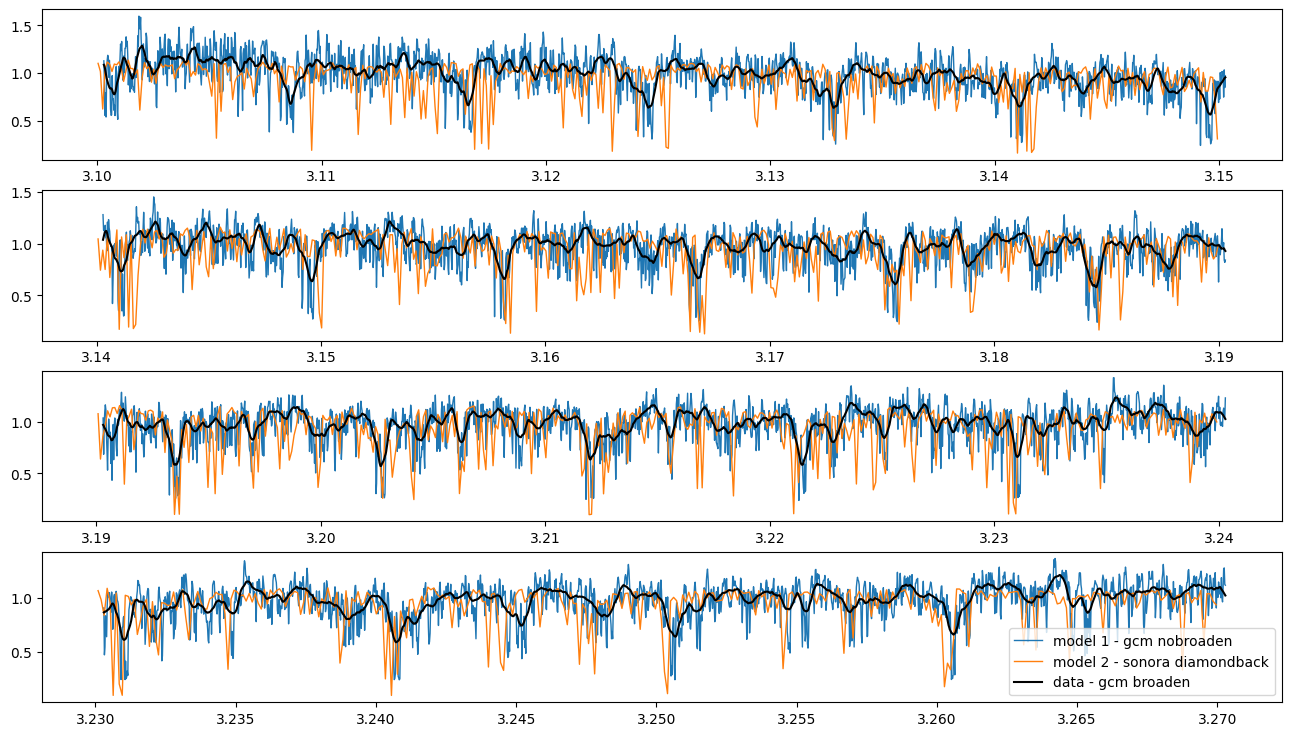

In [13]:
t=0
rvgcm = 9.e-5 #um
#rvgcm = 0
plt.figure(figsize=(16,9))
for c in range(nchip):
    wlmin, wlmax = l_orders[c]
    wlind = np.where((modwl>wlmin) & (modwl<wlmax))[0]
    print(len(wlind))
    plt.subplot(nchip,1,c+1)
    plt.plot(wav[c]*(1+rvgcm), template[t,c], color='tab:blue', lw=1, label=f'model 1 - gcm nobroaden')
    plt.plot(modwl[wlind], modflux[wlind]/np.nanmedian(modflux[wlind]), color='tab:orange', lw=1, label=f'model 2 - sonora diamondback')
    plt.plot(wav[c]*(1+rvgcm), observed[t,c], color='k', label=f'data - gcm broaden')
plt.legend()

Checking fits

In [14]:
resultdir = f"{homedir}/uoedrive/result/fitted/diamondback"
reslist = sorted(glob.glob(f'{resultdir}/METIS_W1049B_L_*.txt'))
chisq_avg = []
chisq_min = []
modelname = []
for file in reslist:
    data = np.loadtxt(file, skiprows=1)
    order, obs, chisq, vsini, lld, rv = data.T
    chisq_avg.append(np.nanmean(chisq))
    chisq_min.append(np.nanmin(chisq))
    modelname.append(file.split(".")[-2][-12:])

In [15]:
# sort chisq
modelname, chisq_min, chisq_avg = zip(*sorted(zip(modelname, chisq_min, chisq_avg), 
    key=lambda x: x[2]))
for i in range(10):
    print(modelname[i], chisq_min[i], chisq_avg[i])

t1500g1000f2 0.29 0.648375
t1200g1000f1 0.37 0.651625
t1500g1000f3 0.18 0.657625
t1600g1000f3 0.29 0.6601250000000001
t1300g1000f1 0.4 0.66825
t1600g1000f2 0.38 0.70625
t1700g1000f4 0.3 0.7085
t1400g1000f1 0.45 0.70975
t1600g1000f4 0.19 0.7148749999999999
t1500g1000f1 0.47 0.735125


In [16]:
bestmodelname = 't1400g1000f2'
with open(f'{resultdir}/METIS_W1049B_L_{bestmodelname}.pickle', 'rb') as f:
    data = pickle.load(f)
res = np.loadtxt(f'{resultdir}/METIS_W1049B_L_fitting_results_{bestmodelname}.txt', skiprows=1)
order, obs, chisq, vsini, lld, rv = res.T
rvs = np.nanmedian(rv.reshape(nchip, 20), axis=1)
rvs

array([1.0090e-07, 1.1450e-10, 8.9025e-09, 1.8350e-05])

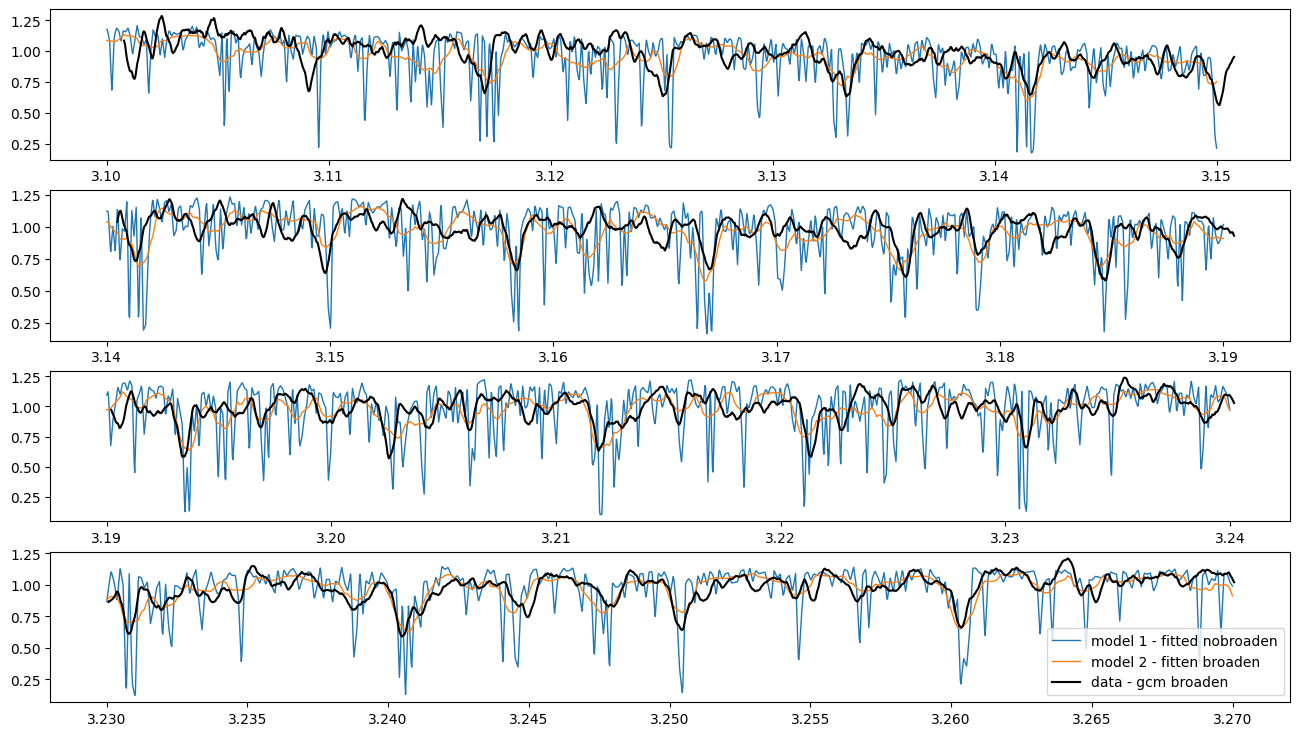

In [17]:
t=0
rv = [25.e-5, 15.e-5, 6e-5, 1.8e-05]
plt.figure(figsize=(16,9))
for c in range(nchip):
    wlmin, wlmax = l_orders[c]
    wlind = np.where((modwl>wlmin) & (modwl<wlmax))[0]
    plt.subplot(nchip,1,c+1)
    plt.plot(data['chiplams'][t,c], data['chipmodnobroad'][t,c], color='tab:blue', lw=1, label=f'model 1 - fitted nobroaden')
    plt.plot(data['chiplams'][t,c], data['chipmods'][t,c], color='tab:orange', lw=1, label=f'model 2 - fitten broaden')
    plt.plot(data['chiplams'][t,c]*(1+rv[c]), data['observed'][t,c], color='k', label=f'data - gcm broaden')
plt.legend()

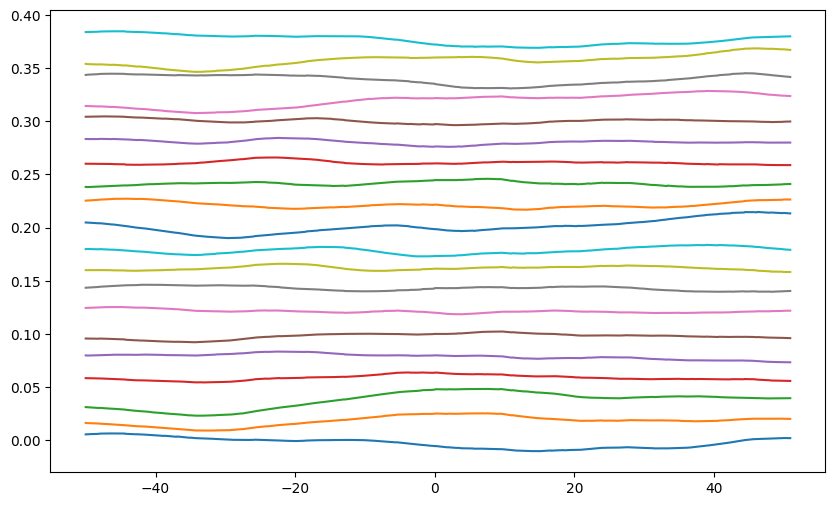

In [18]:
# Constants
c_km_s = 3e5  # Speed of light [km/s]

def doppler_shift_flux(wl_obs, wl_rest, flux_rest, rv):
    """Doppler-shift model flux to observer frame."""
    wl_rest_for_obs = wl_obs / (1 + rv / c_km_s)
    return np.interp(wl_rest_for_obs, wl_rest, flux_rest, left=1, right=1)

def compute_ccf(wl_data, data_resid, wl_model, model_resid, rv_grid):
    """Compute normalized CCF over RV grid."""
    ccf = np.zeros(len(rv_grid))
    for i, rv in enumerate(rv_grid):
        model_interp = doppler_shift_flux(wl_data, wl_model, model_resid, rv)
        ccf[i] = np.sum(data_resid * model_interp)
    ccf /= np.max(np.abs(ccf))  # Normalize
    return ccf

ccfs = []
for t in range(20):
    c = 3
    wl = data['chiplams'][t,c] # High-res grid
    #true_rv = 5.0  # True planet RV [km/s]
    model_flux = data['chipmodnobroad'][t,c]
    data_flux = data['observed'][t,c]
    data_resid = data_flux - 1  # Residuals (subtract continuum)
    model_resid = model_flux - 1

    # Compute CCF
    rv_grid = np.arange(-50, 51, 0.1)
    ccf = compute_ccf(wl, data_resid, wl, model_resid, rv_grid)
    ccfs.append(ccf)

ccfs = np.array(ccfs)

plt.figure(figsize=(10,6))
for t in range(20):
    plt.plot(rv_grid, ccfs[t]-np.nanmedian(ccfs,axis=0)+0.02*t, label=f'Time {t}')

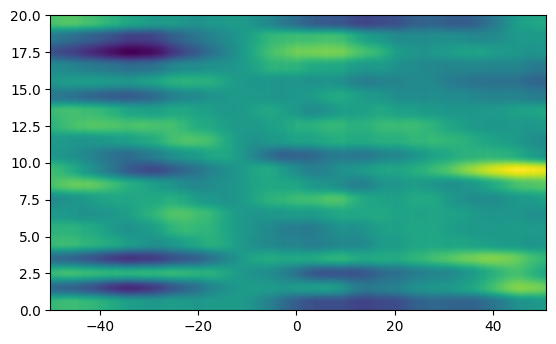

In [19]:
plt.imshow(ccfs-np.nanmedian(ccfs,axis=0), aspect=3, extent=[rv_grid[0], rv_grid[-1], 0, 20], cmap='viridis')

In [20]:
def make_deltaspec(loc, ew, win, **kw):
    """
    Create a delta-function line spectrum based on a wavelength grid
    and a list of line locations and equivalent widths.

    :INPUTS:
       loc -- location of lines in the emission frame of reference

       ew  -- equivalent widths of lines, in units of wavelength grid.
               Positive values are emission lines.

       win -- wavelength grid in the emission frame, with values
              monotonically increasing (best if it is linearly spaced)

       All inputs should be lists or one-dimensional arrays of scalars

    :OPTIONAL_INPUTS:
       cont=None -- set continuum values in the emission frame;

       nearest=False  -- if True, use full pixels instead of partial

       verbose=False  -- if True, print out various messages

    :OUTPUTS:
      s  -- delta-function line spectrum, with a continuum level of zero
    
    :EXAMPLE: (NEEDS TO BE UPDATED!):
       ::

          w   = [2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7]
          loc = [2.1, 2.35, 2.62]
          ew  = [0.1, .02, .01]
          s = linespec(loc, ew, w)
          print s  #  --->  [0, 1, 0, 0.1, 0.1, 0, 0.08, 0.02]

    :NOTE:  This may give incorrect results for saturated lines.
    """
    # 2008-12-05 13:31 IJC: Created
    # 2008-12-10 13:30 IJC: Added continuum option, reworked code some.
    # 2008-12-12 12:33 IJC: Removed RV option

    # Check inputs
    loc = np.array(loc).copy().ravel()
    ew  = np.array(ew ).copy().ravel()
    win = np.array(win).copy().ravel()

    defaults = dict(cont=None, nearest=False, verbose=False)
    for key in defaults:
        if (not key in kw):
            kw[key] = defaults[key]
    verbose = bool(kw['verbose'])
    nearest = bool(kw['nearest'])
    contset = kw['cont']!=None

    if contset:
        cont = np.array(kw['cont']).copy()
        if len(cont)!=len(win):
            print( "Wavelength grid and continuum must have the same length!")
            return -1
    else:
        cont = np.ones(win.shape)

    nlines = len(loc)
    if nlines != len(ew):
        if verbose:  print( "len(loc)>>" + str(len(loc)))
        if verbose:  print( "len(ew)>>" + str(len(ew)))
        print( "Line locations and equivalent widths must have same length!")
        return -1

    # Only use lines in the proper wavelength range
    nlineinit = len(loc)
    lind = (loc>=win.min()) * (loc<=win.max())
    loc = loc[lind]
    ew  =  ew[lind]
    nlines = len(loc)

    s = cont.copy()
    d = np.diff(win).mean()

    if verbose:  print( "s>>" + str(s))

    for ii in range(nlines):
        lineloc = loc[ii]
        lineew  = ew[ii]
        index = (win<lineloc).sum() - 1
        if nearest:
            s[index+1] = s[index]-cont[index]*lineew/d
        elif index==len(win):
            s[index] = s[index] - cont[index]*lineew/d
        else:
            s[index] = s[index] - lineew*cont[index]* \
                (win[index+1] - lineloc)/d/d
            s[index+1] = s[index+1] - lineew*cont[index+1] * \
                (lineloc - win[index])/d/d
        
        if verbose:  
            print( "(lineloc, lineew)>>" + str((lineloc, lineew)))
            print( "(index, d)>>" + str((index,d)))

    if verbose:
        print( "(nlineinit, nline)>>" + str((nlineinit, nlines)))
    return s

In [21]:
line_file = f'../data/linelists/linbroad_L_edited.clineslsd'
with open(line_file, 'r') as f:
    raw = f.readlines()
dat = np.zeros([len(raw), 2], dtype=float)                                                 
for i, line in enumerate(raw):                                         
    dat[i,:]= list(map(float, line.split()[0:2]))
lineloc = dat[:,0]/1e4
lineew = dat[:,1]/1e3

rv=0
shift = 1. + rv
wlind = np.where((wl>np.min(l_orders)) & (wl<np.max(l_orders)))[0]
dwl = wl[wlind]
deltaspec = make_deltaspec(lineloc*shift, lineew, dwl, verbose=False)

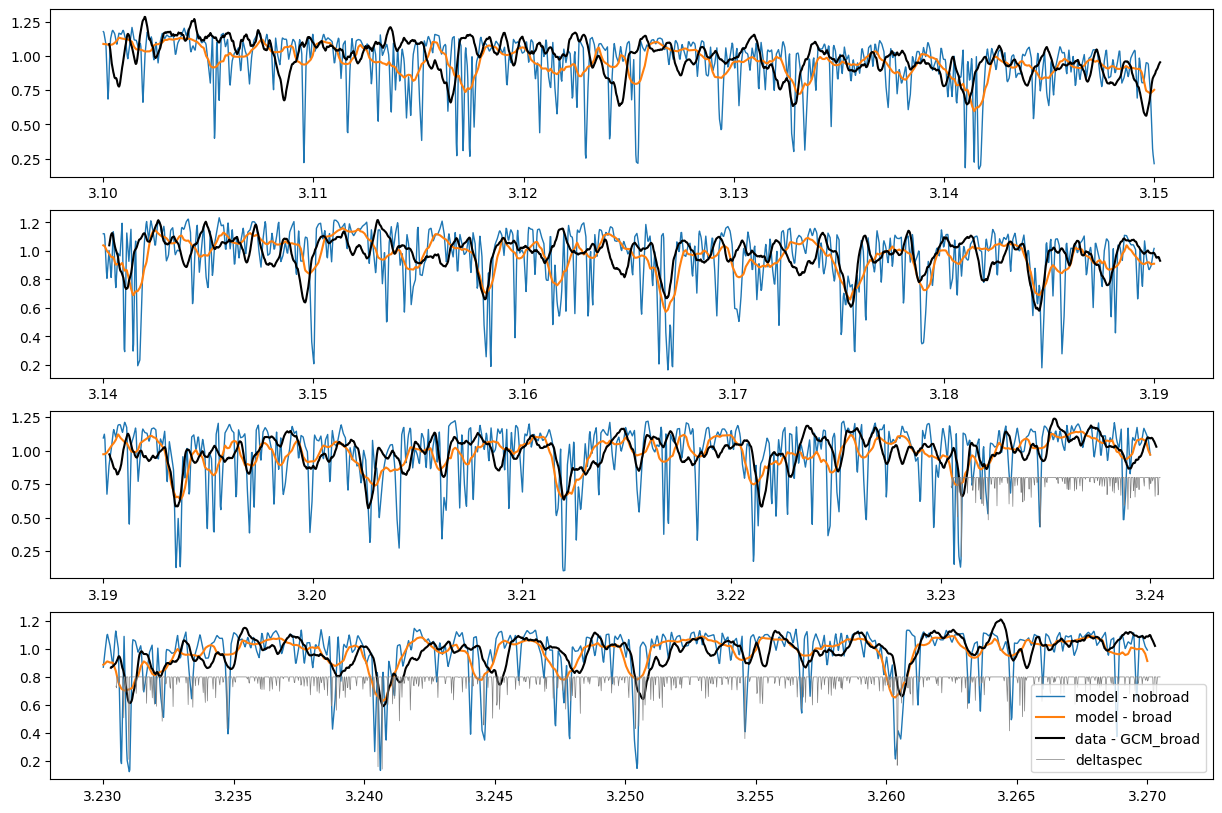

In [22]:
plt.figure(figsize=(15,10))
t=0
rv_ll = [35e-5, 25.e-5, 15e-5, 15e-5] #um
for chip in range(4):
    wlmin, wlmax = l_orders[chip]
    #print(f"chip={chip}, wl=({data['chiplams'][t,chip].min():.4f}, {data['chiplams'][t,chip].max():.4f})")
    plt.subplot(4,1,chip+1)
    plt.plot(data['chiplams'][t,chip], data['chipmodnobroad'][t,chip], color='tab:blue', linewidth=1, label='model - nobroad')
    plt.plot(data['chiplams'][t,chip], data['chipmods'][t,chip], color="tab:orange",label='model - broad')
    #plt.plot(wav[chip]*(1+rvgcm), np.nanmedian(template[:,chip,:],axis=0), color='k', linewidth=1, label=f'GCM_nobroad')
    plt.plot(wav[chip]*(1+rvgcm), observed[t,chip], color='k',label=f'data - GCM_broad')
    for line in lineloc:
        if line > wlmin and line < wlmax:
            plt.axvline(line*shift, ymax=0.8, ymin=0.2, color='r', alpha=0.0)
    dwlind = np.where((dwl>wlmin) & (dwl<wlmax))
    plt.plot(dwl[dwlind]*(1+rv_ll[chip]), 0.8+deltaspec[dwlind]/60000, linewidth=0.5, color="grey", label='deltaspec')
plt.legend();

Doppler imaging

In [23]:
import lsd_utils as lsd
from scipy import interpolate

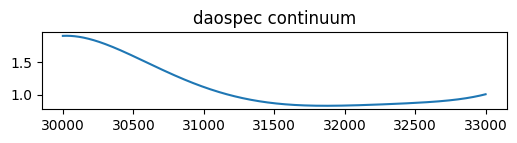

In [65]:
cont_file = f'../data/linelists/linbroad_LC.fits'
line_file = f'../data/linelists/linbroad_L_edited.clineslsd'
lineloc, lineew, _ = lsd.dao_getlines(line_file)
pspec_cont = fits.getdata(cont_file)
hdr_pspec_cont = fits.getheader(cont_file)
wspec = hdr_pspec_cont['crval1'] + np.arange(pspec_cont.size)*hdr_pspec_cont['cdelt1']
pspec_cont = pspec_cont /1e11
spline = interpolate.UnivariateSpline(wspec, pspec_cont, s=0.0, k=1.0) #set up interpolation over the continuum measurement
plt.figure(figsize=(6,1))
plt.plot(wspec, pspec_cont)
plt.title("daospec continuum")
plt.show()

In [88]:
# Compute LSD velocity grid:
nk=100
nobs=20
goodchips=[0,1,2,3]
#pad=50
wav_angs = (np.median(data["chiplams"], axis=0) * 1e4)
print(wav_angs.shape)
dbeta = np.diff(wav_angs).mean()/wav_angs.mean()
dx = - dbeta * np.arange(np.floor(-nk/2.+.5), np.floor(nk/2.+.5))
dv = c_km_s*dx # km/s
npix=2000
rv_ll = [35e-5, 25.e-5, 15e-5, 15e-5]

# Compute LSD:
kerns = np.zeros((nobs, nchip, nk), dtype=float)
modkerns = np.zeros((nobs, nchip, nk), dtype=float)
deltaspecs = np.zeros((nobs, nchip, npix), dtype=float)
for i, jj in enumerate(goodchips): 
    print("chip", jj)
    for kk in range(nobs):
        shift = 1. + rv_ll[jj]  # best rv shift for Callie is 9e-5
        deltaspec = lsd.make_deltaspec(lineloc*shift, lineew, wav_angs[i], verbose=False, cont=spline(wav_angs[i]))
    
        m,kerns[kk,i],b,c = lsd.dsa(deltaspec, observed[kk,i], nk)
        m,modkerns[kk,i],b,c = lsd.dsa(deltaspec, template[kk,i], nk) 
        deltaspecs[kk,i] = deltaspec #/np.abs(np.nanmin(deltaspec))

(4, 2000)
chip 0
chip 1
chip 2
chip 3


In [89]:
dv

array([ 111.75124507,  109.51622017,  107.28119527,  105.04617036,
        102.81114546,  100.57612056,   98.34109566,   96.10607076,
         93.87104586,   91.63602096,   89.40099605,   87.16597115,
         84.93094625,   82.69592135,   80.46089645,   78.22587155,
         75.99084665,   73.75582175,   71.52079684,   69.28577194,
         67.05074704,   64.81572214,   62.58069724,   60.34567234,
         58.11064744,   55.87562253,   53.64059763,   51.40557273,
         49.17054783,   46.93552293,   44.70049803,   42.46547313,
         40.23044822,   37.99542332,   35.76039842,   33.52537352,
         31.29034862,   29.05532372,   26.82029882,   24.58527392,
         22.35024901,   20.11522411,   17.88019921,   15.64517431,
         13.41014941,   11.17512451,    8.94009961,    6.7050747 ,
          4.4700498 ,    2.2350249 ,   -0.        ,   -2.2350249 ,
         -4.4700498 ,   -6.7050747 ,   -8.94009961,  -11.17512451,
        -13.41014941,  -15.64517431,  -17.88019921,  -20.11522

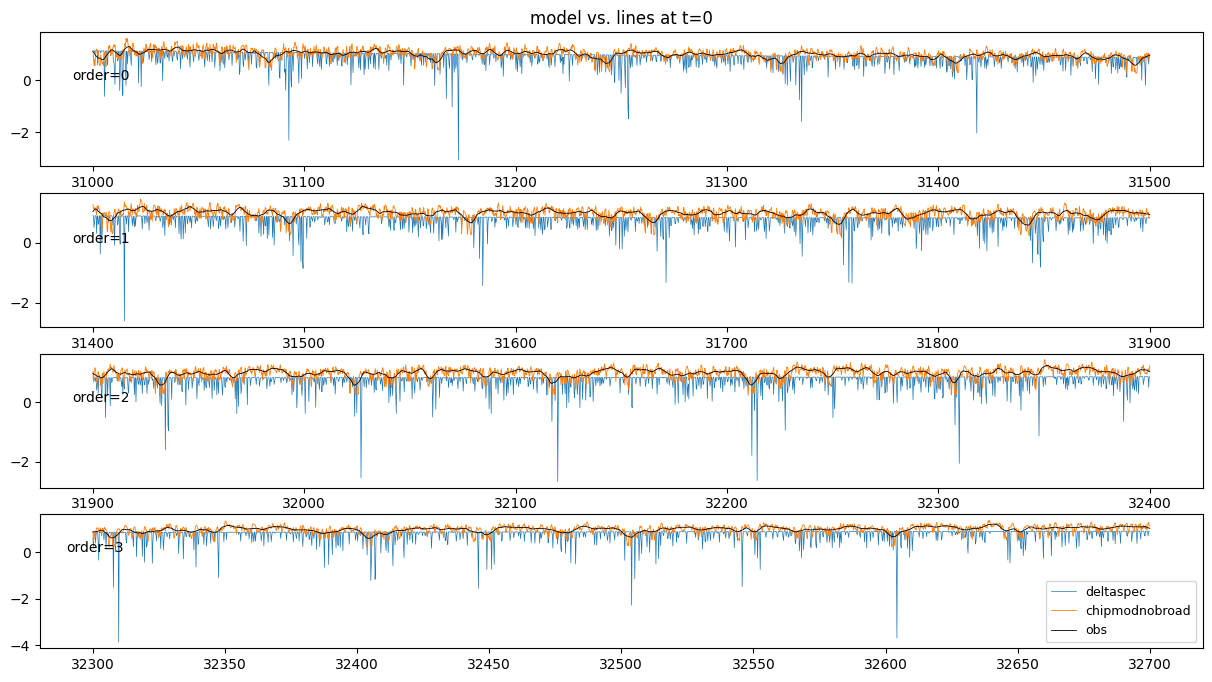

In [90]:
# Plot lines vs. model
plt.figure(figsize=(15, 2*nchip))
t=0
for i, jj in enumerate(goodchips):
    plt.subplot(nchip,1,i+1)
    plt.plot(wav_angs[i], deltaspecs[t,i], linewidth=0.5, color='C0', label="deltaspec")
    plt.plot(wav_angs[i], template[t,i], linewidth=0.6, color='C1', label="chipmodnobroad")
    plt.plot(wav_angs[i], observed[t,i], linewidth=0.6, color='k', label="obs")
    plt.text(x=wav_angs[i].min()-10, y=0, s=f"order={jj}")
    if i==0:
        plt.title(f"model vs. lines at t={t}")
plt.legend(loc=4, fontsize=9)
plt.show()

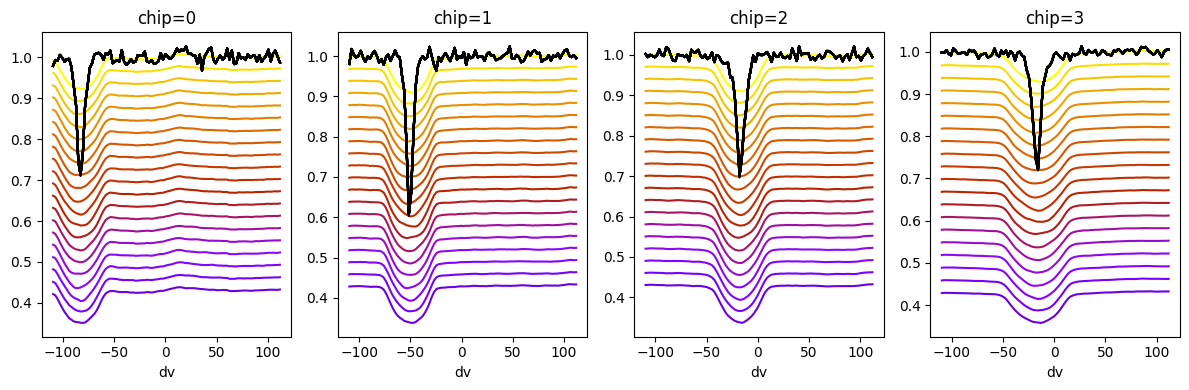

In [91]:
gap=0.03
colors = [cm.gnuplot_r(x) for x in np.linspace(0, 1, nobs+4)]
plt.figure(figsize=(nchip*3,4))
for i, jj in enumerate(goodchips):
    plt.subplot(1, nchip, i+1)
    for n in range(nobs):
        plt.plot(dv, 1 - kerns[n,i] - gap*n, color=colors[n])
        plt.plot(dv, 1 - modkerns[n,i], color='k')
    plt.title(f"chip={jj}")
    plt.xlabel("dv")
plt.tight_layout()

In [72]:
intrinsic_profiles = np.array([modkerns[:,i].mean(0) for i in range(nchip)])

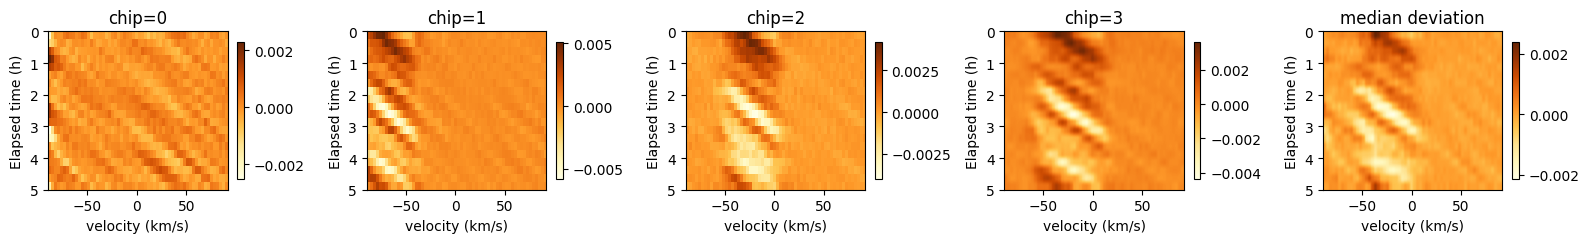

In [92]:
s = 20
period = 5
aspect = 2
uniform_profiles = np.zeros((nchip, nk))
obskerns_norm = 1. - kerns
plt.figure(figsize=(nchip*4,2.5))
for i, jj in enumerate(goodchips):
    uniform_profiles[i] = obskerns_norm[:,i].mean(axis=0) # is each chip's mean kern over epoches
    plt.subplot(1,nchip+1,i+1)
    plt.imshow(obskerns_norm[:,i,s:-s]-uniform_profiles[i,s:-s], 
        extent=(dv.max()-s, dv.min()+s, period, 0),
        aspect=int((nk-s)/period*aspect),
        cmap='YlOrBr') # positive diff means dark spot
    plt.xlim(dv.min()+s, dv.max()-s),
    plt.xlabel("velocity (km/s)")
    plt.ylabel("Elapsed time (h)")
    plt.colorbar(fraction=0.035)
    plt.title(f"chip={jj}")
    mean_dev = np.median(np.array([obskerns_norm[:,i]-uniform_profiles[i] for i in range(nchip)]), axis=0) # mean over chips
plt.subplot(1, nchip+1,i+2)
plt.imshow(mean_dev[:,s:-s], 
    extent=(dv.max()-s, dv.min()+s, period, 0),
    aspect=int((nk-s)/period*aspect),
    cmap='YlOrBr') # positive diff means dark spot
plt.xlim(dv.min()+s, dv.max()-s),
plt.xlabel("velocity (km/s)")
plt.ylabel("Elapsed time (h)")
plt.colorbar(fraction=0.035)
plt.title(f"median deviation")
plt.tight_layout()